In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.5
fsize=12
plt.rcParams.update({'font.size': 12})
import cartopy.feature as cfeature

def plot_map_multizoom(var,lon,lat,title=None,vmax=None,vmin=None,colorbar_label=None,axs=None,fig=None,list_zoom_extent=[[-20, 0, 40, 60]],cmap='RdBu_r',list_zoom_ax = [[0.25, 0.10, 0.5, 0.5]],lat_mask=None,lognorm=None,cbox='k',contour=None,contour_levels=None):

    if not axs:
        fig, axs = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.Robinson()},
                        figsize=(11*1,7.5*1))
        #p0 = plt.pcolormesh(lon2D, lat2D, norm_uv, cmap='jet',vmax=1)
    #vmax_glob=np.nanmax(var)
    #vmin_glob=np.nanmin(var)
    if lat_mask is not None :
        axs.hlines(lat_mask,-180,180,color='k', alpha=1, linestyle='--',transform=ccrs.PlateCarree())
        axs.hlines(-lat_mask,-180,180,color='k', alpha=1, linestyle='--',transform=ccrs.PlateCarree())

    for spine in axs.spines.values():
        spine.set_zorder(11)  # zorder élevé pour que les bords soient au-dessus des autres éléments


    if lognorm:
        p0 = plt.pcolormesh(lon, lat, var, cmap=cmap,norm=LogNorm(vmin=vmin, vmax=vmax))
    else:  
        p0 = plt.pcolormesh(lon, lat, var, cmap=cmap,vmax=vmax,vmin=vmin,transform=ccrs.PlateCarree())

    if title:
        axs.set_title(title)

    import cartopy
    # projection = cartopy.crs.Mercator()
    axs.add_feature(cartopy.feature.LAND, zorder=3)
    axs.add_feature(cartopy.feature.COASTLINE, zorder=3)
    axs.add_feature(cartopy.feature.LAKES, alpha=0.5, zorder=3)
    axs.add_feature(cartopy.feature.RIVERS, zorder=3)

    #if contour is not None:
    #    plt.contour(lon, lat, contour)
        
    axs.coastlines(resolution='10m', lw=0.5)
    #axs.add_feature(cfeature.LAND.with_scale('50m'), facecolor='#EEEEEE', edgecolor='face',alpha=1)

    # optional add grid lines
    p0.axes.gridlines(color='k', alpha=0.2, linestyle='--', linewidth=1,zorder=10)

    # draw parallels/meridiens and write labels
    gl = p0.axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                            linewidth=0.1, color='black', alpha=0.5, linestyle='--')
    # adjust labels to taste
    gl.top_labels = True
    gl.right_labels = False
    gl.bottom_labels = False
    gl.left_labels = True
    #gl.xlabels_bottom = False
    gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
    gl.xlocator = mticker.FixedLocator([-120, -60, 0,  60, 120])
    #gl.xformatter = LONGITUDE_FORMATTER
    #gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

    #get size and extent of axes:
    axpos = axs.get_position()
    pos_x = axpos.x0+axpos.width + 0.01# + 0.25*axpos.width
    pos_y = axpos.y0
    cax_width = 0.02
    cax_height = axpos.height
    #create new axes where the colorbar should go.
    #it should be next to the original axes and have the same height!
    pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
    cbar=plt.colorbar(p0, cax=pos_cax)
    if colorbar_label:
        cbar.set_label(colorbar_label)

    axs.text(0.98, 0.98, "a",
            transform=axs.transAxes,
            fontsize=12, fontweight='bold',
            va='top', ha='right',
            bbox=dict(facecolor='none', alpha=0.7, edgecolor='none'))
    i=0

    for zoom_ax,zoom_extent in zip(list_zoom_ax,list_zoom_extent):

        lon_mg,lat_mg = np.meshgrid(lon,lat)
        var_f = np.where(lat_mg > zoom_extent[2] , var, np.nan)
        var_f = np.where(lat_mg < zoom_extent[3] , var_f, np.nan)
        var_f = np.where(lon_mg < zoom_extent[1] , var_f, np.nan)
        var_f = np.where(lon_mg > zoom_extent[0] , var_f, np.nan)

        if not(vmax):
            vmax=np.nanmax(var_f)
            vmin=np.nanmin(var_f)


        # Ajouter un zoom sur une région spécifique
        ax_zoom = fig.add_axes(zoom_ax, projection=ccrs.PlateCarree())
        ax_zoom.set_extent(zoom_extent, crs=ccrs.PlateCarree())  # Exemple de zoom sur l'Europe

            # projection = cartopy.crs.Mercator()
        ax_zoom.add_feature(cartopy.feature.LAND, zorder=3)
        ax_zoom.add_feature(cartopy.feature.COASTLINE, zorder=3)
        ax_zoom.add_feature(cartopy.feature.LAKES, alpha=0.5, zorder=3)
        ax_zoom.add_feature(cartopy.feature.RIVERS, zorder=3)
        
        for spine in ax_zoom.spines.values():
            spine.set_zorder(11)  # zorder élevé pour que les bords soient au-dessus des autres éléments


        box_kuro_s = [140,157,30,36]
        box_kuro_n = [140,157,36,42]
        # Ajouter les contours de la zone zoomée sur la carte principale
        zoom_rect = plt.Rectangle((box_kuro_s[0], box_kuro_s[2]),
                                box_kuro_s[1] - box_kuro_s[0],
                                box_kuro_s[3] - box_kuro_s[2],
                                linewidth=2, edgecolor="darkblue", facecolor='none',linestyle='--',
                                transform=ccrs.PlateCarree(),zorder=3)
        
        ax_zoom.add_patch(zoom_rect)
        
        if i==1:
            ax_zoom.text(box_kuro_s[1] - 4, box_kuro_s[2] + 3, f"{box_kuro_s_diff_eke:.3g}%",
                        transform=ccrs.PlateCarree(),
                        fontsize=12, color='darkblue',
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='k'))
            ax_zoom.text(box_kuro_n[1] - 4.5, box_kuro_n[2] + 3, f"+{box_kuro_n_diff_eke:.1f}%",
                transform=ccrs.PlateCarree(),
                fontsize=12, color='darkred',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='k'))      
            
            ax_zoom.text(0.98, 0.98, "c",
            transform=ax_zoom.transAxes,
            fontsize=12, fontweight='bold',
            va='top', ha='right',
            bbox=dict(facecolor='none', alpha=0.7, edgecolor='none'))
        else:
            ax_zoom.text(zoom_extent[0] + 2, zoom_extent[3] - 4, f"+{box_moz_diff_eke:.3g}%",
            transform=ccrs.PlateCarree(),
            fontsize=14, color='darkred',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='k'))

            ax_zoom.text(0.98, 0.98, "b",
            transform=ax_zoom.transAxes,
            fontsize=12, fontweight='bold',
            va='top', ha='right',
            bbox=dict(facecolor='none', alpha=0.7, edgecolor='none'))
        i=+1

        """
        if i==1:
            ax_zoom.text(box_kuro_s[1] - 4, box_kuro_s[2] + 3, "-8.1%",
                        transform=ccrs.PlateCarree(),
                        fontsize=12, color='darkblue',
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='k'))
            ax_zoom.text(box_kuro_n[1] - 4.5, box_kuro_n[2] + 3, "+16.9%",
                transform=ccrs.PlateCarree(),
                fontsize=12, color='darkred',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='k'))      
            
            ax_zoom.text(0.98, 0.98, "c",
            transform=ax_zoom.transAxes,
            fontsize=12, fontweight='bold',
            va='top', ha='right',
            bbox=dict(facecolor='none', alpha=0.7, edgecolor='none'))
        else:
            ax_zoom.text(zoom_extent[0] + 2, zoom_extent[3] - 4, "+22.3%",
            transform=ccrs.PlateCarree(),
            fontsize=14, color='darkred',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='k'))

            ax_zoom.text(0.98, 0.98, "b",
            transform=ax_zoom.transAxes,
            fontsize=12, fontweight='bold',
            va='top', ha='right',
            bbox=dict(facecolor='none', alpha=0.7, edgecolor='none'))
        i=+1
        """
        zoom_rect = plt.Rectangle((box_kuro_n[0], box_kuro_n[2]),
                        box_kuro_n[1] - box_kuro_n[0],
                        box_kuro_n[3] - box_kuro_n[2],
                        linewidth=2, edgecolor="darkred", facecolor='none',linestyle='--',
                        transform=ccrs.PlateCarree(),zorder=3)
        

        ax_zoom.add_patch(zoom_rect)

        ax_zoom.coastlines(zorder=5)
        # Ajouter les gridlines avec labels pour les zooms
        gl_zoom = ax_zoom.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                    linewidth=0.5, color='black', alpha=0.5, linestyle='--')
        gl_zoom.top_labels = False
        gl_zoom.right_labels = False
        gl_zoom.bottom_labels = True
        gl_zoom.left_labels = True
        gl_zoom.xlabel_style = {'size': 10, 'color': 'black'}
        gl_zoom.ylabel_style = {'size': 10, 'color': 'black'}
        gl_zoom.ylocator = mticker.MaxNLocator(nbins=3)  # Ajuste le nombre de labels en latitude
        gl_zoom.xlocator = mticker.MaxNLocator(nbins=3)  # Ajuste le nombre de labels en longitude


        if lognorm:
            contour_zoom = ax_zoom.pcolormesh(lon, lat, var, cmap=cmap,transform=ccrs.PlateCarree(),norm=LogNorm(vmin=vmin, vmax=vmax))
        else: 
            contour_zoom = ax_zoom.pcolormesh(lon, lat, var, cmap=cmap,transform=ccrs.PlateCarree(),vmax=vmax,vmin=vmin)
                                
            if contour is not None:
                contours = ax_zoom.contour(lon, lat, contour,transform=ccrs.PlateCarree(),levels=contour_levels,colors="k")
                plt.clabel(contours, inline=True, fontsize=10, fmt='%1.0f')

        #cax = fig.add_axes([ax_zoom.get_position().x1+0.01,ax_zoom.get_position().y0,0.02,ax_zoom.get_position().height])
        #cax = fig.add_axes([ax_zoom.get_position().x0,ax_zoom.get_position().y0-0.03,ax_zoom.get_position().width,0.02])
        #cbar = plt.colorbar(contour_zoom,cax=cax,orientation="horizontal")


        # Ajouter les contours de la zone zoomée sur la carte principale
        zoom_rect = plt.Rectangle((zoom_extent[0], zoom_extent[2]),
                                zoom_extent[1] - zoom_extent[0],
                                zoom_extent[3] - zoom_extent[2],
                                linewidth=2, edgecolor=cbox, facecolor='none',
                                transform=ccrs.PlateCarree(),zorder=11)
        axs.add_patch(zoom_rect)

In [2]:
# Select geostrophy and product 

time_target='2019-11-30'

box_cal = [-135, -115, 20, 50]
box_med = [-5.6, 16.8, 34.6, 44.6]
box_gs = [-80, 0, 30, 60 ]
box_agulhas = [0, 60, -50, -30]
box_NA = [-40, 0, 48, 68]

box_mozemb = [30, 54,-35, -6]
box_kuro = [135, 165, 25, 45]

In [3]:
# Year mean 
from glob import glob 

list_of_maps = sorted(glob("/Odyssey/private/t22picar/multivar_drifter/rec/unet_uv_aoml_15m_10y_11d_bathy_no_sst_mae_neurost_RonanUnet/daily/unet_rec_*.nc"))
imt = xr.open_mfdataset(list_of_maps, combine='nested', concat_dim='time')
ec_imt = imt.ugos**2 + imt.vgos**2

list_of_maps = sorted(glob("/Odyssey/private/t22picar/multivar_drifter/rec/globcurrent_15m_4th/daily/unet_rec_*.nc"))
gc = xr.open_mfdataset(list_of_maps, combine='nested', concat_dim='time')
gc = gc.interp(lon=ec_imt.lon,lat=ec_imt.lat,method="linear")
ec_gc = gc.ugos**2 + gc.vgos**2


list_of_maps = "/Odyssey/public/NeurOST/NeurOST_2010-01-01_2020-01-31_4th.nc"
duacs = xr.open_dataset(list_of_maps).sel(time=slice("2019-01-01","2019-12-31")) #.isel(lat=slice(4, -4)).isel(lon=slice(4, -4))
ec_duacs = (duacs.ugos**2 + duacs.vgos**2) / 2



EKE (1 year mean)

In [6]:
u_prime = duacs.ugos - duacs.ugos.mean(dim="time").values
v_prime = duacs.vgos - duacs.vgos.mean(dim="time").values
eke_duacs = (u_prime**2 + v_prime**2) / 2

ugos_mean = imt.ugos.mean(dim="time").values #imt.ugos.rolling(time=30, center=True, min_periods=1).mean() #
vgos_mean = imt.vgos.mean(dim="time").values #imt.vgos.rolling(time=30, center=True, min_periods=1).mean() #
u_prime = imt.ugos - ugos_mean
v_prime = imt.vgos - vgos_mean
eke_imt = (u_prime**2 + v_prime**2) / 2

ugos_mean = gc.ugos.mean(dim="time").values #gc.ugos.rolling(time=30, center=True, min_periods=1).mean() #
vgos_mean = gc.vgos.mean(dim="time").values #gc.vgos.rolling(time=30, center=True, min_periods=1).mean() #
u_prime = gc.ugos - ugos_mean
v_prime = gc.vgos - vgos_mean
eke_gc = (u_prime**2 + v_prime**2) / 2

EKE IMT VS GC

In [ ]:
list_zoom_extent=[box_gs,box_agulhas,box_mozemb,box_kuro]
list_zoom_ax = [[0.1, 0.65, 0.5, 0.5],[0.1, -0.11, 0.5, 0.5],[0.6, -0.11, 0.5, 0.5],[0.6, 0.65, 0.5, 0.5]]

list_zoom_extent=[box_mozemb,box_kuro]
list_zoom_ax = [[0.4, -0.2, 0.5, 0.5],[0.5, 0.7, 0.5, 0.5]]

# GC
diff_gc = eke_imt-eke_gc
diff_gc = diff_gc.mean(dim="time").values * 10000 #cm2.s-2

list_zoom_extent=[box_mozemb,box_kuro]
list_zoom_ax = [[0.39, -0.25, 0.5, 0.5],[0.5, 0.75, 0.5, 0.5]]

mean_eke_gc = eke_gc.mean(dim="time").values * 10000 #cm2.s-2

box_kuro_s = [140,157,30,36]
box_kuro_n = [140,157,36,40]

eke_gc_kuro_s = eke_gc.sel(lon=slice(140,157)).sel(lat=slice(30,36))
eke_imt_kuro_s = eke_imt.sel(lon=slice(140,157)).sel(lat=slice(30,36))
diff_gc_kuro_s = eke_imt_kuro_s-eke_gc_kuro_s
diff_gc_kuro_s = diff_gc_kuro_s.mean(dim="time").values
box_kuro_s_diff_eke = np.nanmean(diff_gc_kuro_s)*100 / np.nanmean(eke_gc_kuro_s)

eke_gc_kuro_n = eke_gc.sel(lon=slice(140,157)).sel(lat=slice(36,42))
eke_imt_kuro_n = eke_imt.sel(lon=slice(140,157)).sel(lat=slice(36,42))
diff_gc_kuro_n = eke_imt_kuro_n-eke_gc_kuro_n
diff_gc_kuro_n = diff_gc_kuro_n.mean(dim="time").values
box_kuro_n_diff_eke = np.nanmean(diff_gc_kuro_n)*100 / np.nanmean(eke_gc_kuro_n)

eke_gc_moz = eke_gc.sel(lon=slice(box_mozemb[0],box_mozemb[1])).sel(lat=slice(box_mozemb[2],box_mozemb[3]))
eke_imt_moz = eke_imt.sel(lon=slice(box_mozemb[0],box_mozemb[1])).sel(lat=slice(box_mozemb[2],box_mozemb[3]))
diff_gc_moz = eke_imt_moz-eke_gc_moz
diff_gc_moz = diff_gc_moz.mean(dim="time").values
box_moz_diff_eke = np.nanmean(diff_gc_moz)*100 / np.nanmean(eke_gc_moz)

print(box_kuro_s_diff_eke)
print(box_kuro_n_diff_eke)
print(box_moz_diff_eke)

list_zoom_extent=[box_mozemb,box_kuro]
list_zoom_ax = [[0.015, -0.25, 0.5, 0.5],[0.45, -0.25, 0.5, 0.5]]

vmax=500
#levels = [-50,-30,-10,10,30,60]
plot_map_multizoom(diff_gc,ec_imt.lon,ec_imt.lat,lat_mask=None,vmin=-vmax,vmax=vmax,colorbar_label="$\overline{EKE_{IMT-OSC_{neurost}} - EKE_{GC}}$ $[cm^{2}.s^{-2}]$ ",list_zoom_ax=list_zoom_ax,list_zoom_extent=list_zoom_extent)

#plt.savefig(f"../figures/Figure_eke_imt_neu_gc.png", dpi = 300)

1.1701601522023972
33.869132424901956
22.35613111868367


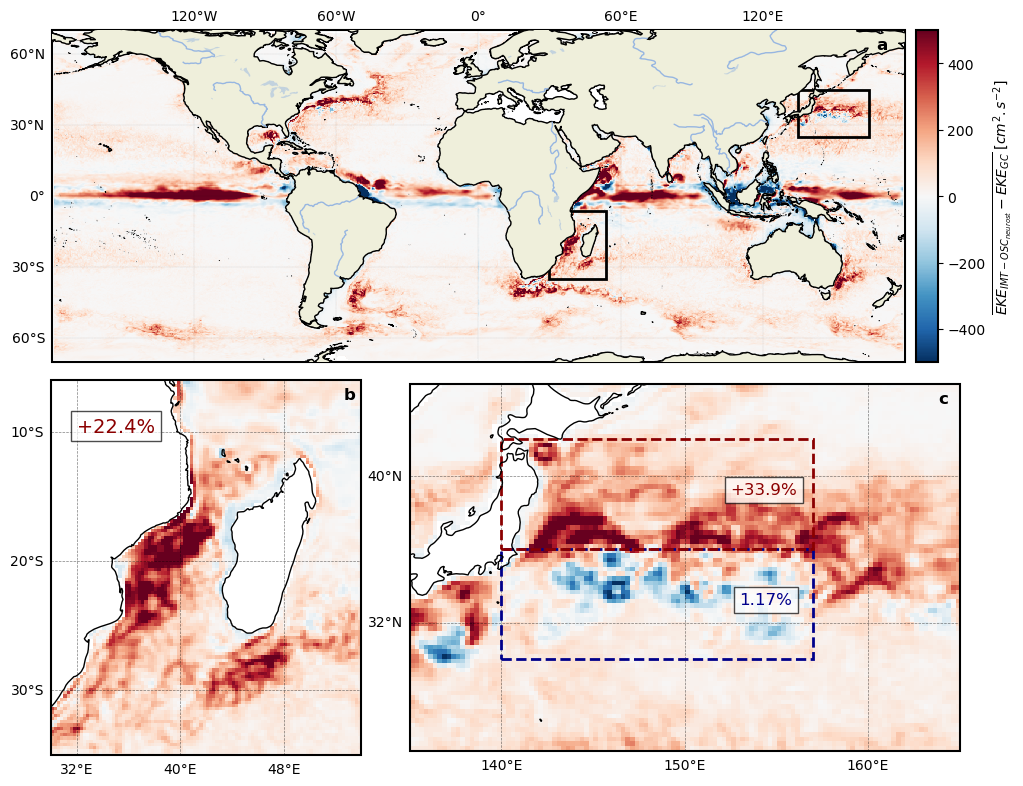

EKE neurost vs neurost

In [7]:
# GC
diff_gc = eke_imt-eke_duacs
diff_gc = diff_gc.mean(dim="time").values * 10000 #cm2.s-2


In [8]:
box_kuro_s = [140,157,30,36]
box_kuro_n = [140,157,36,40]

eke_gc_kuro_s = eke_duacs.sel(lon=slice(140,157)).sel(lat=slice(30,36))
eke_imt_kuro_s = eke_imt.sel(lon=slice(140,157)).sel(lat=slice(30,36))
diff_gc_kuro_s = eke_imt_kuro_s-eke_gc_kuro_s
diff_gc_kuro_s = diff_gc_kuro_s.mean(dim="time").values
box_kuro_s_diff_eke = np.nanmean(diff_gc_kuro_s)*100 / np.nanmean(eke_gc_kuro_s)

eke_gc_kuro_n = eke_duacs.sel(lon=slice(140,157)).sel(lat=slice(36,42))
eke_imt_kuro_n = eke_imt.sel(lon=slice(140,157)).sel(lat=slice(36,42))
diff_gc_kuro_n = eke_imt_kuro_n-eke_gc_kuro_n
diff_gc_kuro_n = diff_gc_kuro_n.mean(dim="time").values
box_kuro_n_diff_eke = np.nanmean(diff_gc_kuro_n)*100 / np.nanmean(eke_gc_kuro_n)

eke_gc_moz = eke_duacs.sel(lon=slice(box_mozemb[0],box_mozemb[1])).sel(lat=slice(box_mozemb[2],box_mozemb[3]))
eke_imt_moz = eke_imt.sel(lon=slice(box_mozemb[0],box_mozemb[1])).sel(lat=slice(box_mozemb[2],box_mozemb[3]))
diff_gc_moz = eke_imt_moz-eke_gc_moz
diff_gc_moz = diff_gc_moz.mean(dim="time").values
box_moz_diff_eke = np.nanmean(diff_gc_moz)*100 / np.nanmean(eke_gc_moz)

print(box_kuro_s_diff_eke)
print(box_kuro_n_diff_eke)
print(box_moz_diff_eke)

-14.29399727078491
8.992851394915382
12.364203800058494


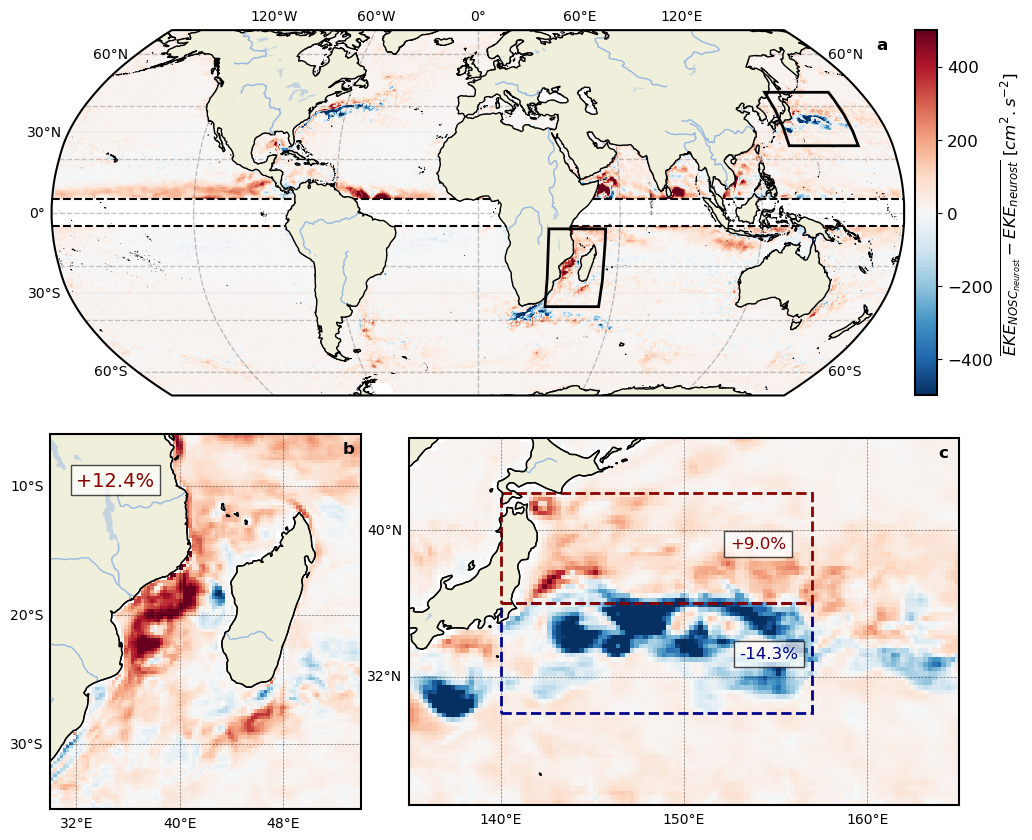

In [14]:
list_zoom_extent=[box_mozemb,box_kuro]
list_zoom_ax = [[0.015, -0.3, 0.5, 0.5],[0.45, -0.3, 0.5, 0.5]]

vmax=500
#levels = [-50,-30,-10,10,30,60]
plot_map_multizoom(diff_gc,ec_imt.lon,ec_imt.lat,lat_mask=5,vmin=-vmax,vmax=vmax,colorbar_label="$\overline{EKE_{NOSC_{neurost}} - EKE_{neurost}}$ $[cm^{2}.s^{-2}]$ ",list_zoom_ax=list_zoom_ax,list_zoom_extent=list_zoom_extent)
plt.savefig(f"../figures/Figure_cyclo_neu.png", dpi = 300,bbox_inches='tight')

EKE IMT neurost - Ekman

In [8]:
# Year mean 
from glob import glob 

#list_of_maps = sorted(glob("/Odyssey/private/t22picar/multivar_drifter/rec/unet_uv_aoml_15m_10y_11d_bathy_no_sst_mae_neurost_RonanUnet/daily/unet_rec_*.nc"))
#imt = xr.open_mfdataset(list_of_maps, combine='nested', concat_dim='time') #.isel(lat=slice(4, -4)).isel(lon=slice(4, -4))
#ec_imt = (imt.ugos**2 + imt.vgos**2)/2

list_of_maps = "/Odyssey/private/t22picar/data/uv/GC_daily/Ekman/globcurrent_15m_ekman_2019.nc"
ek = xr.open_dataset(list_of_maps).isel(depth=0)
ek = ek.rename({"longitude":"lon"})
ek = ek.rename({"latitude":"lat"})
#gc = gc.transpose('time','lat','lon')
ek = ek.interp(lon=imt.lon,lat=imt.lat,method="linear")
ek


<xarray.Dataset> Size: 5GB
Dimensions:  (time: 366, lat: 560, lon: 1440)
Coordinates:
    depth    int16 2B 15
  * time     (time) datetime64[ns] 3kB 2019-01-01 2019-01-02 ... 2020-01-01
  * lon      (lon) float32 6kB -180.0 -179.7 -179.5 -179.2 ... 179.4 179.7 179.9
  * lat      (lat) float32 2kB -69.99 -69.73 -69.48 -69.23 ... 69.47 69.72 69.97
Data variables:
    ue       (time, lat, lon) float64 2GB nan 0.01256 0.01228 ... nan nan nan
    ve       (time, lat, lon) float64 2GB nan -0.003 -0.002779 ... nan nan nan
Attributes:
    institution:               CLS
    Conventions:               CF-1.6
    title:                     Daily mean total surface and 15m velocities
    contact:                   servicedesk.cmems@mercator-ocean.eu
    references:                Mulet S., Rio M.-H., Etienne H., Artana C., Ca...
    copernicusmarine_version:  2.0.1

In [9]:
ek = ek.sel(time=slice("2019-01-01","2019-12-31"))

In [11]:
imt_geos_u = (imt.ugos -  ek.ue)#.values
imt_geos_v = (imt.vgos -  ek.ve)#.values

ugos_mean = imt_geos_u.mean(dim="time").values #imt.ugos.rolling(time=30, center=True, min_periods=1).mean() #
vgos_mean = imt_geos_v.mean(dim="time").values #imt.vgos.rolling(time=30, center=True, min_periods=1).mean() #
u_prime = imt_geos_u - ugos_mean
v_prime = imt_geos_v - vgos_mean
eke_imt = (u_prime**2 + v_prime**2) / 2

In [12]:
# GC
diff_gc = eke_imt-eke_duacs
diff_gc = diff_gc.mean(dim="time").values * 10000 #cm2.s-2

In [13]:
box_kuro_s = [140,157,30,36]
box_kuro_n = [140,157,36,40]

eke_gc_kuro_s = eke_duacs.sel(lon=slice(140,157)).sel(lat=slice(30,36))
eke_imt_kuro_s = eke_imt.sel(lon=slice(140,157)).sel(lat=slice(30,36))
diff_gc_kuro_s = eke_imt_kuro_s-eke_gc_kuro_s
diff_gc_kuro_s = diff_gc_kuro_s.mean(dim="time").values
box_kuro_s_diff_eke = np.nanmean(diff_gc_kuro_s)*100 / np.nanmean(eke_gc_kuro_s)

eke_gc_kuro_n = eke_duacs.sel(lon=slice(140,157)).sel(lat=slice(36,42))
eke_imt_kuro_n = eke_imt.sel(lon=slice(140,157)).sel(lat=slice(36,42))
diff_gc_kuro_n = eke_imt_kuro_n-eke_gc_kuro_n
diff_gc_kuro_n = diff_gc_kuro_n.mean(dim="time").values
box_kuro_n_diff_eke = np.nanmean(diff_gc_kuro_n)*100 / np.nanmean(eke_gc_kuro_n)

eke_gc_moz = eke_duacs.sel(lon=slice(box_mozemb[0],box_mozemb[1])).sel(lat=slice(box_mozemb[2],box_mozemb[3]))
eke_imt_moz = eke_imt.sel(lon=slice(box_mozemb[0],box_mozemb[1])).sel(lat=slice(box_mozemb[2],box_mozemb[3]))
diff_gc_moz = eke_imt_moz-eke_gc_moz
diff_gc_moz = diff_gc_moz.mean(dim="time").values
box_moz_diff_eke = np.nanmean(diff_gc_moz)*100 / np.nanmean(eke_gc_moz)

print(box_kuro_s_diff_eke)
print(box_kuro_n_diff_eke)
print(box_moz_diff_eke)

-15.391093774218263
7.403505344789992
8.960254400557272


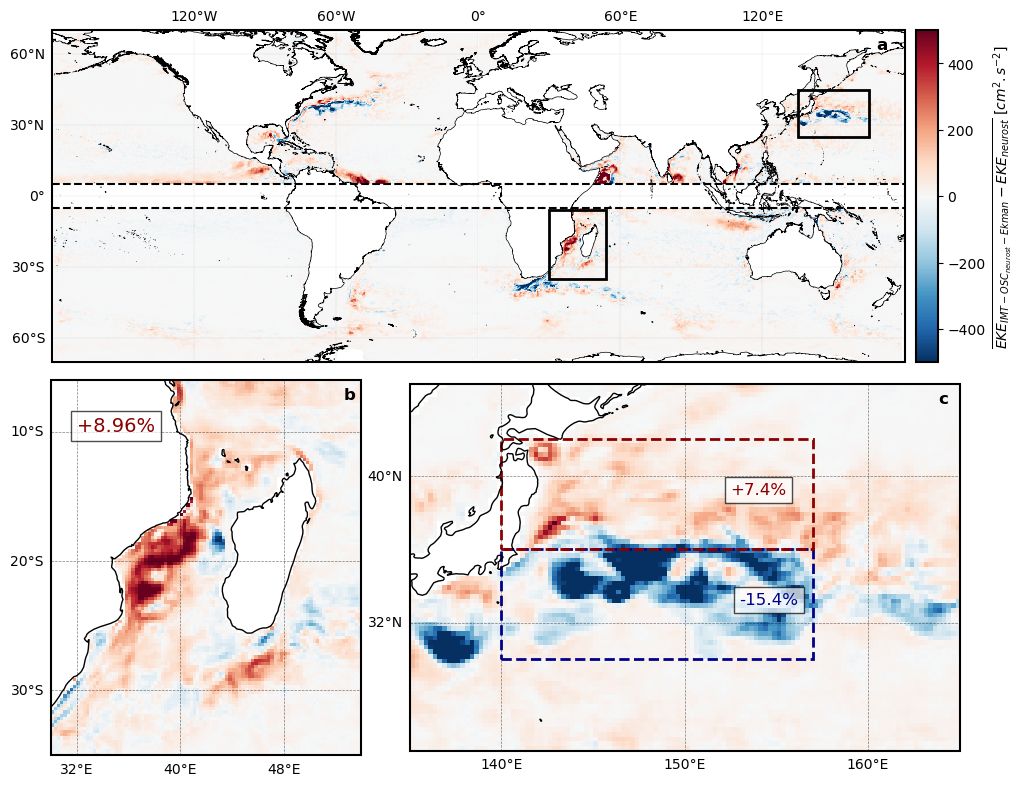

In [22]:
list_zoom_extent=[box_mozemb,box_kuro]
list_zoom_ax = [[0.015, -0.25, 0.5, 0.5],[0.45, -0.25, 0.5, 0.5]]

vmax=500
#levels = [-50,-30,-10,10,30,60]
plot_map_multizoom(diff_gc,ec_imt.lon,ec_imt.lat,lat_mask=5,vmin=-vmax,vmax=vmax,colorbar_label="$\overline{EKE_{IMT-OSC_{neurost} - Ekman} - EKE_{neurost}}$ $[cm^{2}.s^{-2}]$ ",list_zoom_ax=list_zoom_ax,list_zoom_extent=list_zoom_extent)
plt.savefig(f"../figures/Figure_eke_imt_neu_ek_neu.png", dpi = 300)